**This notebook analyzes our output data. The overall goal is to assess directional assignment performance as a function of event-energy. In general, assigning event direction at low energies is more challenging both because the 3D event images have less information to use for classification, but even more importantly, the charge asymmetries that can be used to assign event direction in a physically motivated way tend to be obscured (and often in unpredictable ways), as can be seen in the image below.**

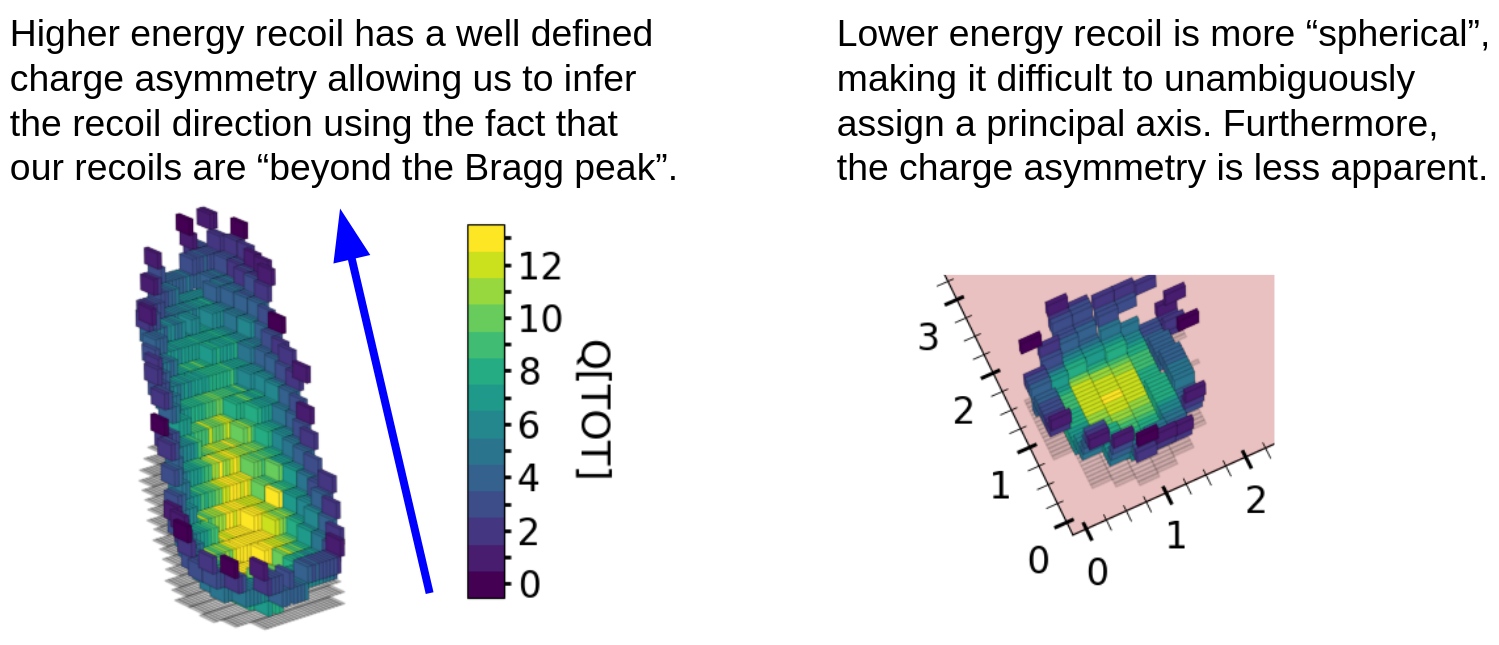

**We will compare the directional assignment performance of our 3DCNN to the physically motivated "baseline" method that splits the track in half along its principal axis and assigns direction based on the fraction of charge on each half of the track. More details on this baseline method can be found [in this paper](https://arxiv.org/abs/2111.03841), [this paper](https://arxiv.org/abs/2106.13079), or [this paper](https://arxiv.org/abs/2106.15829)**

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
from numba import jit
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rc('legend', fontsize=18)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('axes', labelsize=26)
plt.rc('axes', titlesize=26)

#  Load data

In [2]:
df = pd.read_feather('../data/sample_evaluated.feather')

### We trained on a balanced class distribution and we expect equal numbers of events in each hemisphere given a directionally isotropic dataset, thus $p = 0.5$ should be a reasonable classification threshold for our events

In [3]:
#Implement p = 0.5 as the classification threshold

threshold = 0.5
df['correct_assign'] = 1
index = df.query('(prob < %s & truth == 1) | (prob > %s & truth == 0)'%(threshold,threshold)).index.to_numpy()
df['correct_assign'][index] = 0

### The distribution of $p$ is approximately symmetric about $p=0.5$ indicating that $p=0.5$ is an appropriate classification threshold for our analysis without the need of an explicit precision-recall analysis

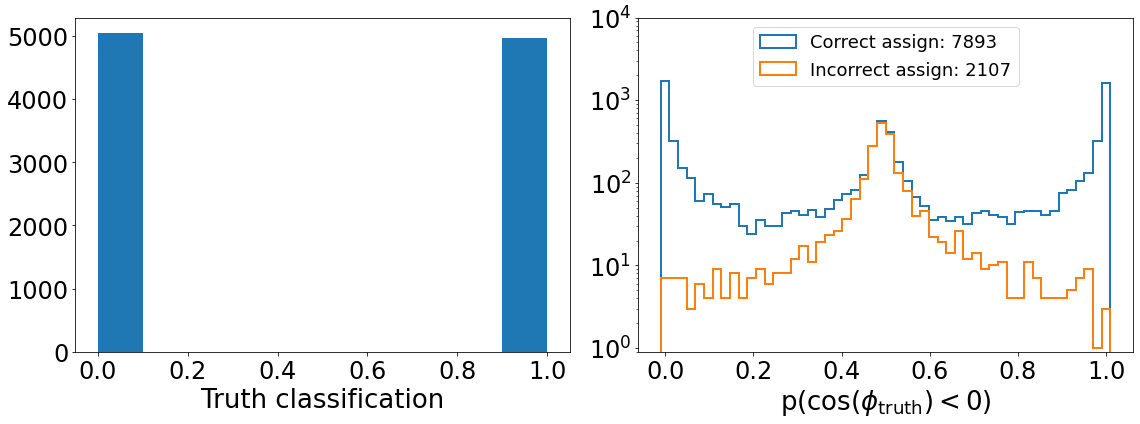

In [4]:
plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
plt.hist(df['truth'])
plt.xlabel('Truth classification')
plt.subplot(1,2,2)
key = 'prob'
plt.hist(df.query('correct_assign == 1')[key],bins = 52, range=(-0.01,1.01),label='Correct assign: %s'%(len(df.query('correct_assign == 1'))),histtype = 'step', lw = 2)
plt.hist(df.query('correct_assign == 0')[key],bins = 52, range=(-0.01,1.01),label='Incorrect assign: %s'%(len(df.query('correct_assign == 0'))),histtype = 'step', lw = 2)
plt.xlabel(r'p($\cos(\phi_\mathrm{truth}) < 0)$')
plt.legend(loc='upper center')
plt.ylim(0.9,10000)
plt.yscale('log')
plt.tight_layout()
plt.show()

# Let's next compute $w\equiv2 \left|p-\frac{1}{2}\right|$, which is a one-sided measure of classification confidence. We're untimately interested in correctly assigning events in both directions, so $w$ is a good variable for this

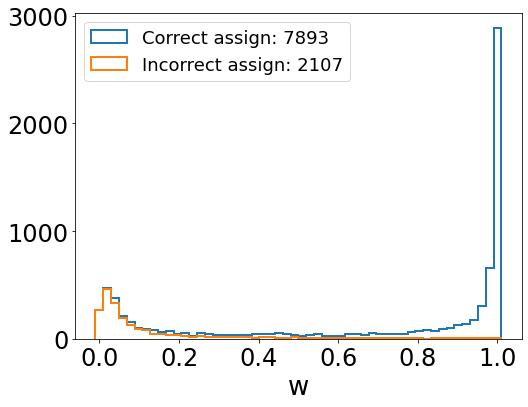

In [5]:
df['w'] = 2*np.abs(df['prob']-1/2)

key = 'w'
plt.figure(figsize = (8,6))
plt.hist(df.query('correct_assign == 1')[key],bins = 52, range=(-0.01,1.01),label='Correct assign: %s'%(len(df.query('correct_assign == 1'))),histtype = 'step', lw = 2)
plt.hist(df.query('correct_assign == 0')[key],bins = 52, range=(-0.01,1.01),label='Incorrect assign: %s'%(len(df.query('correct_assign == 0'))),histtype = 'step', lw = 2)
plt.xlabel('w')
plt.legend(loc = 'upper left')
plt.show()

# We're interested in evaluating directional efficiency, $\rm \varepsilon_{dir}$, which is the fraction of events with correct assigned directional hemisphere, as a function of energy. At low energies there is less information in our 3D events, making it more difficult to correctly assign direction.

We also evaluate directional efficiency using a physically motivated baseline method here. The sample data already has the relevant quantities (HCF, and baseline_correct_assign) computed. Details for computing these can be found in the papers quoted in the preamble of this document.

In [6]:
Es = np.linspace(5,105,11)

sel_eff = 0.5

cuts     = {}
effs     = {}
eff_errs = {}

for method in ['CNN','baseline']:
    cuts[method] = []
    effs[method] = []
    eff_errs[method] = []
    for i in range(1,len(Es)):
        tmp = df.query('%s <= truth_energy < %s'%(Es[i-1],Es[i]))
        if method == 'CNN':
            cut = np.quantile(tmp['w'],sel_eff) #selections corresponding to us keeping the best 50% of events at each energy step 
            eff = len(tmp.query('(w > %s) & correct_assign == 1'%(cut)))/len(tmp.query('(w > %s)'%(cut)))
            efferr = np.sqrt(eff*(1-eff)/len(tmp.query('(w > %s)'%(cut))))
        else:
            cut = np.quantile(tmp['HCF'],sel_eff) #HCF is the charge fraction on the "head" side of the track
            eff = len(tmp.query('(HCF < %s) & baseline_correct_assign == 1'%(cut)))/len(tmp.query('(HCF < %s)'%(cut)))
            efferr = np.sqrt(eff*(1-eff)/len(tmp.query('(HCF < %s)'%(cut))))
        cuts[method].append(cut)
        effs[method].append(eff)
        eff_errs[method].append(efferr)

# The plot below shows the performance of the best performing 50% of events at each energy step (we call this $\rm \varepsilon_{selection} = 0.5$).

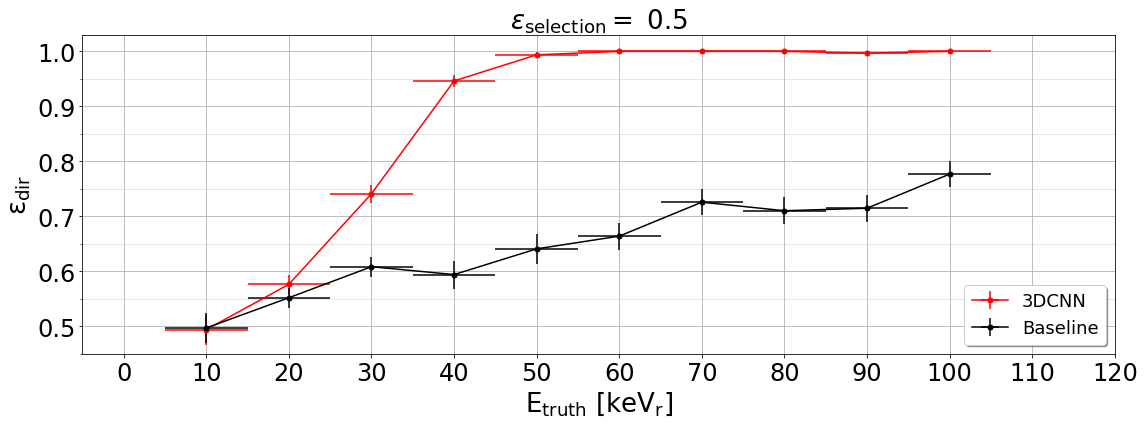

In [7]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
fig, ax = plt.subplots(1,1,figsize = (16,6))
for method,color,label in zip(['CNN','baseline'],['red','k'],['3DCNN','Baseline']):
    ax.errorbar((Es+5)[:-1],effs[method],eff_errs[method],[5 for i in range(0,len(effs[method]))],'o-',
                markersize = 5,color = color, label = label,alpha = 1)
ax.set_ylim(0.5,1.05)
ax.set_xlabel(r'$\rm E_{truth}$ $[\rm keV_{r}]$')
ax.set_ylabel(r'$\rm \varepsilon_{dir}$')
ax.set_xlim(-5,120)
ax.set_xticks([10*i for i in range(0,13)])
ax.set_title(r'$\varepsilon_\mathrm{selection} = $ %s'%(sel_eff))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.grid(which = 'major')
ax.grid(which = 'minor',alpha = 0.4)
ax.legend(shadow = True, fancybox = True, framealpha = 1, loc = 'lower right',ncol = 1)
plt.ylim(0.45,1.03)
plt.tight_layout()
plt.show()

**While neither method gives performance better than a coin flip at 10 keV, by 30 keV, the 3DCNN performs significantly better than the Baseline method.**